
--- Fastest Deinterlined Line ---
The fastest line on average is line GS with an average actual runtime of 1.52 in minutes.

--- Fastest Deinterlined Line (no shuttles) ---
The fastest line on average is line G with an average actual runtime of 36.76 in minutes.

--- Fastest Interlined Line ---
The fastest line on average is line J with an average actual runtime of 54.84 in minutes.


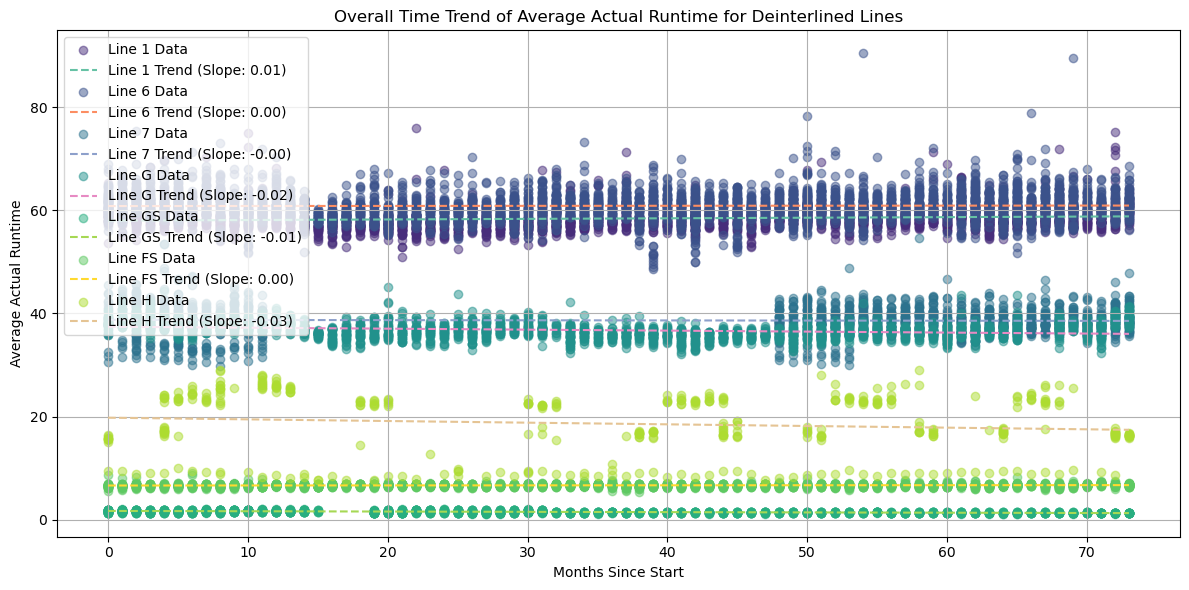


--- Overall Time Trend Analysis for Deinterlined Lines ---

Current fastest Deinterlined line (based on overall average): GS (Average Actual Runtime: 1.52)
Line 1: Trend (per month): slowing down (Slope: 1.12697134e-02), Last Avg Runtime: 59.53 (Month Index: 73)
Line 6: Trend (per month): slowing down (Slope: 1.37060491e-03), Last Avg Runtime: 60.71 (Month Index: 73)
Line 7: Trend (per month): speeding up (Slope: -2.81250856e-03), Last Avg Runtime: 38.66 (Month Index: 73)
Line G: Trend (per month): speeding up (Slope: -1.89675963e-02), Last Avg Runtime: 37.91 (Month Index: 73)
Line GS: Trend (per month): speeding up (Slope: -5.69210599e-03), Last Avg Runtime: 1.29 (Month Index: 73)
Line FS: Trend (per month): slowing down (Slope: 1.02042203e-03), Last Avg Runtime: 6.38 (Month Index: 73)
Line H: Trend (per month): speeding up (Slope: -3.21633233e-02), Last Avg Runtime: 16.46 (Month Index: 73)

Based on linear regression, the fastest Deinterlined line in the next year (projected) might 

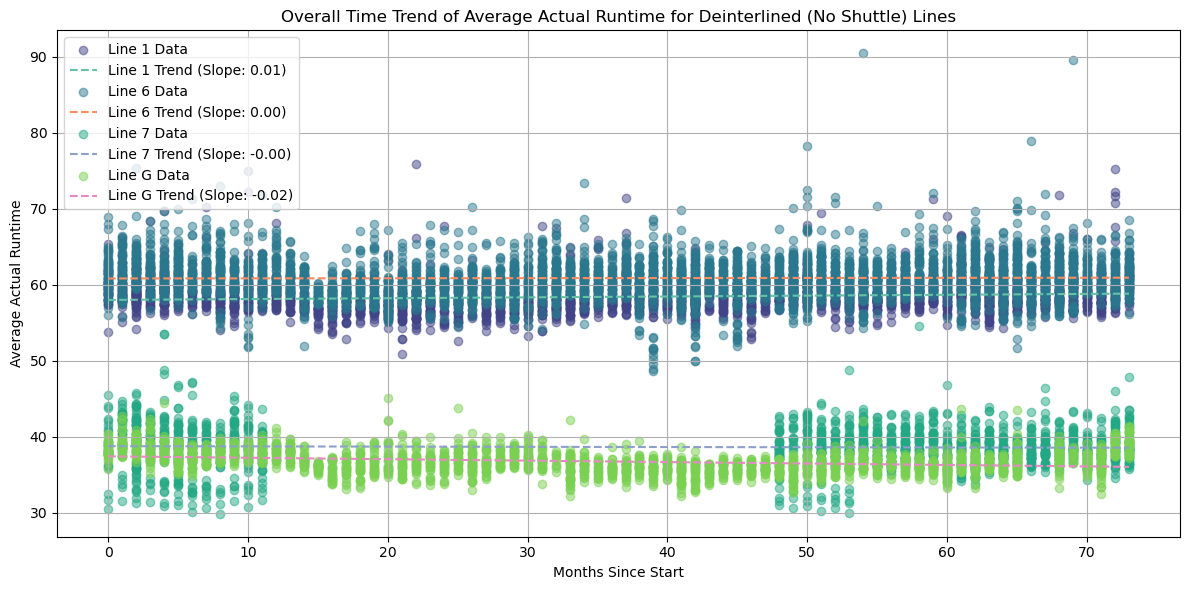


--- Overall Time Trend Analysis for Deinterlined (No Shuttle) Lines ---

Current fastest Deinterlined (No Shuttle) line (based on overall average): G (Average Actual Runtime: 36.76)
Line 1: Trend (per month): slowing down (Slope: 1.12697134e-02), Last Avg Runtime: 59.53 (Month Index: 73)
Line 6: Trend (per month): slowing down (Slope: 1.37060491e-03), Last Avg Runtime: 60.71 (Month Index: 73)
Line 7: Trend (per month): speeding up (Slope: -2.81250856e-03), Last Avg Runtime: 38.66 (Month Index: 73)
Line G: Trend (per month): speeding up (Slope: -1.89675963e-02), Last Avg Runtime: 37.91 (Month Index: 73)

Based on linear regression, the fastest Deinterlined (No Shuttle) line in the next year (projected) might be: G (Projected Average Actual Runtime: 35.82)
This suggests that the current fastest Deinterlined (No Shuttle) line (G) is likely to remain the fastest based on the overall time trend.


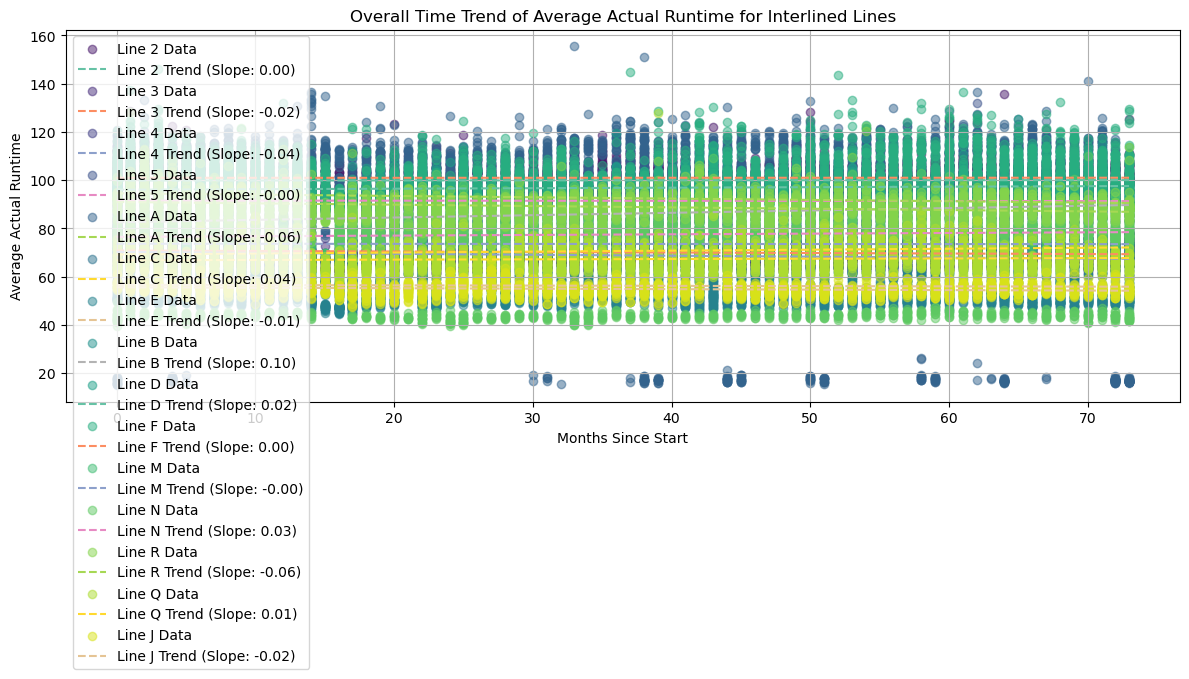


--- Overall Time Trend Analysis for Interlined Lines ---

Current fastest Interlined line (based on overall average): J (Average Actual Runtime: 54.84)
Line 2: Trend (per month): slowing down (Slope: 2.82775535e-03), Last Avg Runtime: 110.68 (Month Index: 73)
Line 3: Trend (per month): speeding up (Slope: -2.11055871e-02), Last Avg Runtime: 78.22 (Month Index: 73)
Line 4: Trend (per month): speeding up (Slope: -3.93406121e-02), Last Avg Runtime: 63.80 (Month Index: 73)
Line 5: Trend (per month): speeding up (Slope: -3.19959120e-03), Last Avg Runtime: 82.20 (Month Index: 73)
Line A: Trend (per month): speeding up (Slope: -5.50314747e-02), Last Avg Runtime: 17.25 (Month Index: 73)
Line C: Trend (per month): slowing down (Slope: 3.97321638e-02), Last Avg Runtime: 68.77 (Month Index: 73)
Line E: Trend (per month): speeding up (Slope: -1.06879612e-02), Last Avg Runtime: 64.81 (Month Index: 73)
Line B: Trend (per month): slowing down (Slope: 9.77970691e-02), Last Avg Runtime: 82.43 (Month I

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None

def arr_averager(a):
    for i in range(0,len(a)):
        a[i] = a[i].mean()

def find_fastest_line(line_dfs):
    fastest_line = None
    fastest_avg_runtime = float('inf')

    for line, df in line_dfs.items():
        if not df.empty and 'Average Actual Runtime' in df.columns:
            avg_runtime = df['Average Actual Runtime'].mean()
            if avg_runtime < fastest_avg_runtime:
                fastest_avg_runtime = avg_runtime
                fastest_line = line
        elif df.empty:
            print(f"Warning: No data available for line {line} to calculate average runtime.")
        else:
            print(f"Warning: 'Average Actual Runtime' column not found for line {line}.")

    if fastest_line:
        print(f"The fastest line on average is line {fastest_line} with an average actual runtime of {fastest_avg_runtime:.2f} in minutes.")
    else:
        print("No line data available with 'Average Actual Runtime' to determine the fastest line.")
    return fastest_line, fastest_avg_runtime

def analyze_speed_trend(line_dfs, category_name):
    fastest_line = None
    fastest_avg_runtime = float('inf')
    trends = {}

    plt.figure(figsize=(12, 6))
    plt.title(f'Overall Time Trend of Average Actual Runtime for {category_name} Lines')
    plt.xlabel('Months Since Start')
    plt.ylabel('Average Actual Runtime')

    # Use a color palette for the data points
    data_palette = sns.color_palette("viridis", len(line_dfs))
    # Use a different color palette for the trend lines
    trend_palette = sns.color_palette("Set2", len(line_dfs))

    line_index = 0
    for line, df in line_dfs.items():
        if not df.empty and 'Average Actual Runtime' in df.columns and 'Month' in df.columns:
            try:
                df['Datetime'] = pd.to_datetime(df['Month'], format='%m/01/%Y', errors='coerce')
                df_cleaned = df.dropna(subset=['Datetime', 'Average Actual Runtime'])
                if not df_cleaned.empty:
                    first_date = df_cleaned['Datetime'].min()
                    df_cleaned['Time_Numeric'] = ((df_cleaned['Datetime'].dt.year - first_date.year) * 12 +
                                                (df_cleaned['Datetime'].dt.month - first_date.month))

                    X = df_cleaned['Time_Numeric'].values.reshape(-1, 1)
                    y = df_cleaned['Average Actual Runtime'].values
                    model = LinearRegression()
                    model.fit(X, y)
                    slope = model.coef_[0]

                    trends[line] = {'slope': slope, 'intercept': model.intercept_,
                                    'time_numeric': df_cleaned['Time_Numeric'],
                                    'runtimes': df_cleaned['Average Actual Runtime']}

                    current_avg_runtime = df_cleaned['Average Actual Runtime'].mean()
                    if current_avg_runtime < fastest_avg_runtime:
                        fastest_avg_runtime = current_avg_runtime
                        fastest_line = line

                    # Plot the data points with one color palette
                    plt.scatter(df_cleaned['Time_Numeric'], df_cleaned['Average Actual Runtime'],
                                label=f'Line {line} Data', alpha=0.5, color=data_palette[line_index])
                    # Plot the trend line with a different color palette
                    plt.plot(df_cleaned['Time_Numeric'], model.predict(X),
                             label=f'Line {line} Trend (Slope: {slope:.2f})', linestyle='--', color=trend_palette[line_index])

                    line_index += 1

                else:
                    print(f"Warning: Not enough valid data (Datetime and runtime) for linear regression on {category_name} line {line}.")

            except Exception as e:
                print(f"Error during linear regression for {category_name} line {line}: {e}")
        elif df.empty:
            print(f"Warning: No data available for {category_name} line {line}.")
        else:
            print(f"Warning: Missing required columns ('Average Actual Runtime' or 'Month') for {category_name} line {line}.")

    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\n--- Overall Time Trend Analysis for {category_name} Lines ---")
    fastest_line_future_prediction = None
    fastest_future_runtime = float('inf')

    if fastest_line and trends:
        print(f"\nCurrent fastest {category_name} line (based on overall average): {fastest_line} (Average Actual Runtime: {fastest_avg_runtime:.2f})")

        for line, trend in trends.items():
            slope = trend['slope']
            intercept = trend['intercept']
            last_time = trend['time_numeric'].max() if not trend['time_numeric'].empty else None
            last_avg_runtime = trend['runtimes'].iloc[-1] if not trend['runtimes'].empty else None

            trend_desc = "slowing down" if slope > 0 else "speeding up" if slope < 0 else "staying relatively constant"
            print(f"Line {line}: Trend (per month): {trend_desc} (Slope: {slope:.8e}), Last Avg Runtime: {last_avg_runtime:.2f} (Month Index: {last_time})")

            if last_time is not None:
                future_time = last_time + 12
                future_runtime = slope * future_time + intercept

                if future_runtime < fastest_future_runtime:
                    fastest_future_runtime = future_runtime
                    fastest_line_future_prediction = line

        if fastest_line_future_prediction:
            print(f"\nBased on linear regression, the fastest {category_name} line in the next year (projected) might be: {fastest_line_future_prediction} (Projected Average Actual Runtime: {fastest_future_runtime:.2f})")
            if fastest_line_future_prediction == fastest_line:
                print(f"This suggests that the current fastest {category_name} line ({fastest_line}) is likely to remain the fastest based on the overall time trend.")
            else:
                print(f"This suggests a potential change in the fastest {category_name} line based on the overall time trend.")
        else:
            print(f"Could not predict the future fastest {category_name} line.")

    else:
        print(f"Could not determine the current fastest {category_name} line or analyze trends.")

DEINTERLINED_TERMINI = {
    '1': ['242ND STREET-BWAY', 'SOUTH FERRY TERMINAL'], #
    '6': ['PELHAM BAY PARK', 'BROOKLYN BRIDGE'], # 6 exp and 6 loc have the same termini, just fewer stops on exp
    '7': ['34TH STREET-HUDSON YARDS', 'FLUSHING-MAIN STREET'], # 7 exp and 7 loc have the same termini, just fewer stops on exp
    'G': ['COURT SQUARE', 'CHURCH AVENUE'], #
    'GS': ['TIMES SQUARE-SHUTTLE', 'GRAND CENTRAL-SHUTTLE'], # may exclude as its a major outlier
    'FS': ['FRANKLIN AVENUE', 'PROSPECT PARK'], #
    'H': ['BROAD CHANNEL', 'BEACH 116TH STREET-ROCKAWAY PARK', 'ROCKAWAY BOULEVARD', 'MOTT AVENUE-FAR ROCKAWAY'] # still known as the H in the database
}
INTERLINED_TERMINI = {
    '2': ['EAST 241ST STREET', 'FLATBUSH AVENUE'], #
    '3': ['148TH STREET-LENOX', 'NEW LOTS AVENUE'], #
    '4': ['WOODLAWN-JEROME AVENUE', 'UTICA AVENUE'], #
    '5': ['DYRE AVENUE', 'FLATBUSH AVENUE', 'EAST 238TH STREET'], #
    'A': ['207TH STREET-8AV', 'LEFFERTS BOULEVARD-OZONE PARK', 'MOTT AVENUE-FAR ROCKAWAY', 'BEACH 116TH STREET-ROCKAWAY PARK'], #
    'C': ['168TH STREET-8AV', 'EUCLID AVENUE'], #
    'E': ['PARSONS/ARCHER-JAMAICA CENTER', 'WORLD TRADE CENTER'], #
    'B': ['BEDFORD PARK BLVD', 'BRIGHTON BEACH'], #
    'D': ['205TH STREET-NORWOOD', 'STILLWELL AVENUE-CONEY ISLAND'], #
    'F': ['179TH STREET-JAMAICA', 'STILLWELL AVENUE-CONEY ISLAND'], #
    'M': ['71ST/CONTINENTAL AVENUE-FOREST HILLS', 'METROPOLITAN AVENUE-MIDDLE VILLAGE'],
    'N': ['STILLWELL AVENUE-CONEY ISLAND', 'DITMARS BOULEVARD-ASTORIA', 'WHITEHALL STREET-SOUTH FERRY'], # W is an N short turn in the database
    'R': ['71ST/CONTINENTAL AVENUE-FOREST HILLS', '95TH STREET-BAY RIDGE'],
    'Q': ['STILLWELL AVENUE-CONEY ISLAND', '96TH STREET-2AV'],
    'J': ['PARSONS/ARCHER-JAMAICA CENTER', 'BROAD STREET'], # J and Z trips are the same, just some have fewer stops.
}

# dataset importing
DATASET = pd.read_csv('../datasets/MTA_EtoE_Times.csv')

# dataset cleaning
DATASET = DATASET.drop(['Time Period', 'Schedule Day Type','Average Speed', 'Average Scheduled Runtime', 'Scheduled Trains', 'Actual Trains', 'Distance', 'Direction', 'Number of Stops', 'Stop Path ID', 'Origin Station ID', 'Destination Station ID',], axis=1)


deinterlined_dataframes = {}
interlined_dataframes = {}

# Process deinterlined lines
for line, termini in DEINTERLINED_TERMINI.items():
    if len(termini) == 2:
        origin, destination = termini
        line_df = DATASET[((DATASET['Origin Station Name'] == origin) & (DATASET['Destination Station Name'] == destination)) |
                           ((DATASET['Origin Station Name'] == destination) & (DATASET['Destination Station Name'] == origin))]
        deinterlined_dataframes[line] = line_df
    elif len(termini) > 2:
        # Handle lines with multiple possible destinations (like the H line)
        conditions = []
        for i in range(len(termini)):
            for j in range(i + 1, len(termini)):
                origin, destination = termini[i], termini[j]
                conditions.append(((DATASET['Origin Station Name'] == origin) & (DATASET['Destination Station Name'] == destination)) |
                                  ((DATASET['Origin Station Name'] == destination) & (DATASET['Origin Station Name'] == origin)))
        if conditions:
            combined_condition = conditions[0]
            for condition in conditions[1:]:
                combined_condition = combined_condition | condition
            line_df = DATASET[combined_condition]
            deinterlined_dataframes[line] = line_df
        else:
            print(f"Warning: No termini pairs found for deinterlined line {line}")
    else:
        print(f"Warning: Invalid number of termini for deinterlined line {line}")

# Process interlined lines
for line, termini in INTERLINED_TERMINI.items():
    conditions = []
    # Handle lines with multiple possible termini
    for origin in termini:
        for destination in termini:
            if origin != destination:
                conditions.append(((DATASET['Origin Station Name'] == origin) & (DATASET['Destination Station Name'] == destination)) |
                                  ((DATASET['Origin Station Name'] == destination) & (DATASET['Origin Station Name'] == origin)))
    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition = combined_condition | condition
        line_df = DATASET[combined_condition]
        interlined_dataframes[line] = line_df
    else:
        print(f"Warning: No valid termini pairs found for interlined line {line}")



for line, df in deinterlined_dataframes.items():
    df.drop(['Origin Station Name', 'Destination Station Name'], axis=1, inplace=True)

for line, df in interlined_dataframes.items():
    df.drop(['Origin Station Name', 'Destination Station Name'], axis=1, inplace=True)

deinterlined_ns_dataframes = deinterlined_dataframes.copy()
deinterlined_ns_dataframes.pop('GS')
deinterlined_ns_dataframes.pop('FS')
deinterlined_ns_dataframes.pop('H')


# Find the fastest deinterlined line
print("\n--- Fastest Deinterlined Line ---")
fastest_deinterlined_line, fastest_deinterlined_runtime = find_fastest_line(deinterlined_dataframes)

print("\n--- Fastest Deinterlined Line (no shuttles) ---")
fastest_deinterlined_ns_line, fastest_deinterlined_ns_runtime = find_fastest_line(deinterlined_ns_dataframes)

# Find the fastest interlined line
print("\n--- Fastest Interlined Line ---")
fastest_interlined_line, fastest_interlined_runtime = find_fastest_line(interlined_dataframes)


# Analyze deinterlined lines
analyze_speed_trend(deinterlined_dataframes, "Deinterlined")

analyze_speed_trend(deinterlined_ns_dataframes, "Deinterlined (No Shuttle)")

# Analyze interlined lines
analyze_speed_trend(interlined_dataframes, "Interlined")